# Computing maximally localized Wannier functions - The `Wannier` class

In crystalline systems, Wannier functions are the real-space counter part of Bloch eigenfunctions. They are obtained by a linear combination of Bloch eigenvectors:

$$\ket{w_{n\mathbf{R}}} = \frac{V}{(2\pi)^2} \int_{BZ} d \mathbf{k} \left(e^{i \mathbf{k} \cdot \mathbf{R}} \sum_m^N  U^{\mathbf{k}}_{mn} e^{i \mathbf{k} \cdot \mathbf{r}} \ket{u_{n\mathbf{k}}}\right)$$

Here, $\ket{w_{n\mathbf{R}}}$ is the n-th Wannier function of unit cell at $\mathbf{r} = \mathbf{R}$, $V$ is the Brillouin zone volume,  $U^{\mathbf{k}}_{mn}$ is a k-dependant unitary matrix and $\ket{u_{n\mathbf{k}}}$ is the n-th Bloch eigenvector at $\mathbf{k}$.

The Wannier functions show two properties that make them particularily interesting:
+ They form an orthonormal basis for the set of bands considered: $\braket{w_{n\mathbf{R}}|w_{n'\mathbf{R}'}} = \delta_{nn'}\delta_{RR'}$.
+ For a given index $n$ the Wannier functions are identical to one another up to a translation: $w_{n\mathbf{R}}(\mathbf{r}) = w_{n,\mathbf{R} + \mathbf{R}'}(\mathbf{r} - \mathbf{R}')$

These two properties make Wannier function very convenient for the study of lattice wavefunctions. Furthermore, because of gauge freedom in the definition of the bloch eigenvectors and the unitary matrix $U^{\mathbf{k}}_{mn}$, There exist an infinite number of Wannier functions for a given system. This makes it possible to chose the set of Wannier functions most appropriate for a given situation. Such a given set of particularily useful Wannier functions is the set of so-called Maximally Localized Wannier Functions (MLWFs) (see [[Marzari1997]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.56.12847)).

The computation of these MLWFs can be performed in multiple ways, here, we implement the original proposal of Marzari and Vanderbilt, which consists in the minimization of the spread functional:

$$ \Omega = \sum_n^N \left< (\bf{r} - \bar{\bf{r}}_n)^2\right> = \sum_n^N \left[ \left<r^2\right>_n - |\bar{\bf{r}}_n|^2 \right]$$

where $\left< r^2 \right>_n = \braket{w_{n0}|r^2|w_{n0}}$ and $\bar{\bf{r}}_n$ is the center of the Wannier function.

To perform this minimization, we follow the procedure implemented in [Wannier90](https://wannier.org/) and outlined [here](https://arxiv.org/abs/0708.0650).

## The `Wannier` class

The `Wannier` class implements a much simplified version of Wannier90, it can compute the MLWFs for a given set of bands, provided the lattice geometry (given by a `Potential` object), a set of aproximate Wannier function centers (usually easy to identify in 2D) and a Schrödinger solver method (such as `FDSolver` and `PWSolver`). It is fully compatible with the framework of the `bloch_schrodinger` package, and thus provides a fully parallel determination of the WFs for an arbitrary number of parameter dimensions.

In this tutorial, we will show how to compute the Wannier functions of an optical honeycomb lattice with a variyng lattice depth and sublattice imbalance. We will show as well how to use the low-level plotting function `create_map` to obtain highly customizable interactive plots.

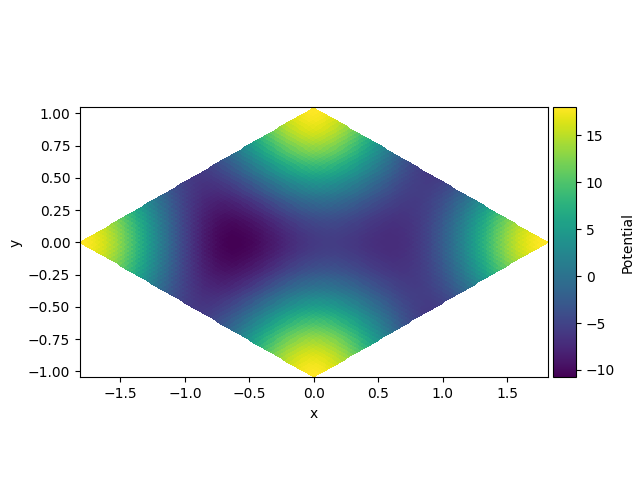

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from bloch_schrodinger.potential import Potential, create_parameter

# Creating the optical lattice, see https://journals.aps.org/pra/abstract/10.1103/PhysRevA.80.043411 for more informations on the lattice.
## The lattice parameters
kl = 2
m = 1
hbar = 1
E_r = hbar**2 * kl**2 / 2 / m
delta = create_parameter('delta', np.linspace(-0.2, 0.2, 3))
s = create_parameter('s', np.linspace(3, 9, 3))

s1 = s + delta
s2 = s - delta

V1 = -s2*E_r
V2 = -s1*E_r

## The lattice geometry
a = 4*np.pi / 3**1.5 / kl
a1 = np.array([3 * a/2, -(3**0.5) * a/2])  # 1st lattice vector
a2 = np.array([3 * a/2, 3**0.5 * a/2])  # 2nd lattice vector

b1 = 3**0.5 * kl * np.array([1, -3**0.5])/2
b2 = 3**0.5 * kl * np.array([1, 3**0.5])/2

k1 = kl * np.array([-3**0.5 / 2 , 1/2])
k2 = kl * np.array([3**0.5 / 2 , 1/2])
k3 = kl * np.array([0,-1])

a1s = np.array([-1, 3**0.5])*2*np.pi/3/a 
a2s = np.array([1, 3**0.5])*2*np.pi/3/a
K = np.array([0, 4*np.pi/3**1.5/a])

## Creating the potential object
na1 = 64
na2 = 64

honeycomb = Potential(
    unitvecs = [a1, a2],
    resolution = (na1, na2),
    v0 = 0,
)

dirs = [
    k1[0] * (honeycomb.x - a1[0]) + k1[1] * honeycomb.y,
    k2[0] * (honeycomb.x - a1[0]) + k2[1] * honeycomb.y,
    k3[0] * (honeycomb.x - a1[0]) + k3[1] * honeycomb.y,
]

for i in range(3):
    honeycomb.add(2*V1*np.cos((dirs[i-1]-dirs[i]) - 2*np.pi/3)/2)
    honeycomb.add(2*V2*np.cos((dirs[i-1]-dirs[i]) + 2*np.pi/3)/2)

%matplotlib widget
honeycomb.plot()
plt.show()

Now that the potential is created, we can instanciate a `Wannier` object and use it to compute the Wannier functions. 

In [2]:
from bloch_schrodinger.wannier import Wannier

foo = Wannier(
    Potential=honeycomb,
    alpha = hbar**2/2/m,
    rec_vecs=[a1s, a2s], # The reciprocal space vectors used to define the Brillouin zone of the lattice
    resolution=(15,15), # The resolution of the k-mesh used to compute the Bloch eigenvectors
    method='pw' # The solver method, either 'pw' for plane waves, or 'fd' for finite-differences
)

We also need an approximate position of the Wannier centers to initialize the spread functional minimization. Here, we already know their exact positions from symmetry considerations.

In [3]:

centers = [
    [-a/2, 0], [a/2, 0]
]

We can now employ the `solve` function, which compute the unitary matrix $U^{\mathbf{k}}_{nm}$. The solve function does not yield directly the Wannier functions, as they are much larger objects than the unitary matrix. They must be computed afterwards using the dedicated `compute_wannier` function.

In [ ]:

U_mnk = foo.solve(
    n_wannier = 2, centers=centers, parallel=True, n_cores=9, blockwargs={'E_lim':300} # We can pass aditional arguments to the Bloch solver using the blockwargs kwarg.
)

# The minimization procedure can sometimes be a bottleneck for the computation of Wannier functions. This is mainly due to the gradient descent algorithm currently implemented. 
# A better method will be implemented in the future.

Computing the Bloch functions...
Performing 2025 diagonalizations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 842 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 1418 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1920 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed:   22.2s finished


storing the results


100%|██████████| 2025/2025 [00:01<00:00, 1135.24it/s]


summing...


100%|██████████| 187/187 [00:17<00:00, 10.57it/s]


Computing 9 sets of Wannier functions


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   2 out of   9 | elapsed:   16.2s remaining:   57.0s
[Parallel(n_jobs=9)]: Done   4 out of   9 | elapsed:   16.4s remaining:   20.5s
[Parallel(n_jobs=9)]: Done   6 out of   9 | elapsed:   18.7s remaining:    9.3s
[Parallel(n_jobs=9)]: Done   9 out of   9 | elapsed:   19.5s finished


Finally, we compute the actual Wannier functions over multiple unit cells using the dedicated class method.

In [5]:

pot, wannier = foo.compute_wannier( 
    U_mnk=U_mnk,
    bounds1=[-2, 3], # The unit cell ranges along the first lattice vector over which to plot the wannier function
    bounds2=[-2, 3], # The unit cell ranges along the second lattice vector over which to plot the wannier function
    coarsen=(1,1), # Wheter to coarsen the resolution of the functions, useful for large bounds or finely resolved potentials
) # This function return a Potential object which is just a tiled version of the original one, as well as the Wannier functions

Computing the mode profiles...


100%|██████████| 15/15 [00:56<00:00,  3.78s/it]


## Interactive 2D plots with the `create_map` functions

Sometimes, the regular `plot_eigenfunction` is not versatile enough for a given plot. It is then possible to use the `create_map` function to create your own fully customizable plots. Here, we are going to plot the signed squared modulus of the Wannier function as a filled contour plot with outlined levels. The `create_map` function will handle the interactive functionallities, while we will focus on the figure style.

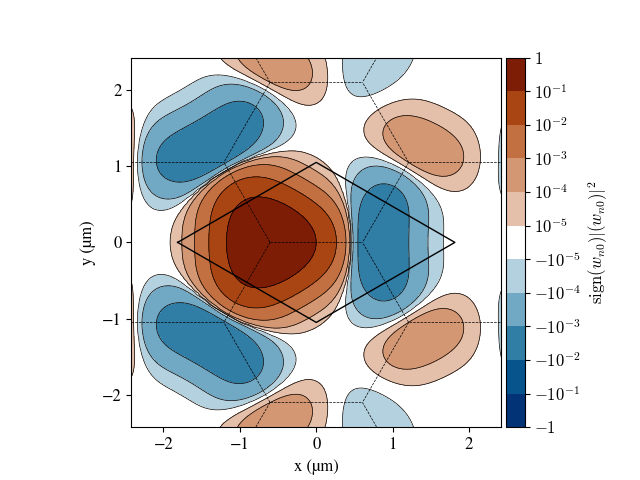

In [23]:
from bloch_schrodinger.plotting import create_map

from cmcrameri.cm import vik
import xarray as xr
from ipywidgets import VBox, interactive_output
from IPython.display import display

wannier = wannier / wannier.max(['a1', 'a2'])
toplot = xr.ufuncs.sign(wannier.real) * abs(wannier)**2

nlevels = 6
levels = np.logspace(-nlevels + 1, 0, nlevels)
levels = np.append(-levels[::-1], levels)

colors = np.linspace(0,1,nlevels*2+1, endpoint=True)[1:]
colors = vik(colors)
colors[nlevels-1] = [1,1,1,1] # making the center color white


tickslabels = ( # A nice formating of the ticks
    [rf"$-10^{{{-exp}}}$" for exp in range(0, nlevels)] + 
    [rf"$10^{{{exp}}}$" for exp in range(-nlevels+1, 1)]
)

tickslabels[0], tickslabels[-1] = "$-1$", "$1$"

template_fcontour = {
    "fkwargs":{
        "levels":levels,
        "colors": colors,
    },
    "colorbar":{
        "kwargs":{
            "label": r"$\text{sign}(w_{n0})|(w_{n0})|^2$",
        },
        "ticks": levels,
        "tickslabel": tickslabels
    },
}

template_contour = {
    "fkwargs":{
        "levels":levels,
        "colors": 'k',
        "linestyles": 'solid',
        "linewidths":0.5
    },
}

fig, ax = plt.subplots()
# First we create the filled contour
sliders, update1, ax = create_map(
    fig, ax,
    dim1='x', dim2='y',
    data=toplot,
    method='contourf',
    template = template_fcontour
)

# Then the outlines
sliders, update2, ax = create_map(
    fig, ax,
    dim1='x', dim2='y',
    data=toplot,
    method='contour',
    template = template_contour
)

# Overlaying the lattice and unit cells
uc = np.array([a1*0, a1, a1+a2, a2, a2*0]) - (a1+a2)/2
ax.plot(uc[:,0], uc[:,1], 'k', linewidth = 1)
posA = np.array([-a/2, 0])
posB = np.array([a/2, 0])
seg1 = np.array([posA, posB])
seg2 = np.array([posA, posB-a1])
seg3 = np.array([posA+a2, posB])
style = dict(color = 'k', linewidth = 0.5, linestyle = 'dashed')
for i in range(-2,3):
    for j in range(-2,3):
        seg1t = seg1 + i*a1[None,:] + + j*a2[None,:]
        seg2t = seg2 + i*a1[None,:] + + j*a2[None,:]
        seg3t = seg3 + i*a1[None,:] + + j*a2[None,:]
        ax.plot(seg1t[:,0], seg1t[:,1], **style)
        ax.plot(seg2t[:,0], seg2t[:,1], **style)
        ax.plot(seg3t[:,0], seg3t[:,1], **style)


ax.set_xlim(-2*a, 2*a)
ax.set_ylim(-2*a, 2*a)
ax.set_aspect('equal')

ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")

# Now we combien the update functions
def update(**kwargs):
    update1(**kwargs)
    update2(**kwargs)


out = interactive_output(update, sliders)
# Display everything
display(VBox(list(sliders.values()) + [out]))
